In [1]:
import numpy as np
import pandas as pd

# plotting 
import matplotlib.pyplot as plt

# data manager and analysis
import vodex as vx
import numan as nu

# writing files
import tifffile as tif

Matplotlib created a temporary config/cache directory at /tmp/matplotlib-ycholpca because the default path (/home/ply/.config/matplotlib) is not a writable directory; it is highly recommended to set the MPLCONFIGDIR environment variable to a writable directory, in particular to speed up the import of Matplotlib and to better support multiprocessing.


# DONT TRUST. IT NEEDS TO BE UPDATED. Project structure: 

Provide the project folder with the "processed" folder created in the previous notebook. 

As you keep going with the analysis, the folder will have the following structure: 


```
...........................................................
....................... DONE in 01 ........................
...........................................................
processed                                               ...
│   experiment.json <-----------------------------------... the file that contains the volume information about the experiment, you are creating it once and will be reusing ever after
│   experiment_dff.json <-------------------------------... the experiment, but files are loaded from the dff movie folder, not from the raw data               
└───dff_movie  <----------------------------------------... the dff movie folder, will be created by this notebook
│   │   dff_movie_0000.tif                              ... individual tif files with the dff movie
│   │   dff_movie_0001.tif                              ...
│   │   ...                                             ...
│++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
│++++++++++++ WILL BE DONE in this notebook +++++++++++++++
│++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
│                                                       +++
└───tscore_volumes  <-----------------------------------+++ t-score tif files
│   │   tscore_SvB.tif <--------------------------------+++ t-score Stimuli vs Blank
│   │                                                   +++
│++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
│++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
│++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
│
│!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
│!!!!!!!!!! ATTENTION: NEXT STEP IS MANUAL STEP !!!!!!!!!!!
│!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
└───spots                                               !!!
│   └───imaris  <---------------------------- ATTENTION !!! You need to put stuff generated by imaris into this folder!!!                                         !!!
│       │   └───tscore_SvB_Statistics                   !!!
│       │       │     tscore_SvB_Position.csv           !!!
│       │       │     tscore_SvB_Diameter.csv           !!!
│       │       │     ...                               !!!
│!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
│!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
│!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
│   │
│   └───signals  <-------------------------------------- json files with the extracted signals, also will have the group info after you added it
│       │   spots_SvB.json
│   └───reports  <---------------------------------- tiffs and pdf with the cells significant in any pairwise comparison
│       └───all_significant  <---------------------- tiffs and pdf with all significant in any way cells
│           │   └───signals  <---------------------- pdfs with signals
│           │       │     ...
│           │   └───images <------------------------ tif masks
│           │       │     ...
│       └───groupped  <----------------------------- tiffs and pdf where the cells are groupped based on signal shape .. or anything else you want
│           │   readme.txt  <----------------------- ATTENTION : you need to describe the groups
│           │   └───signals  <---------------------- pdfs with signals
│           │       │     ...
│           │   └───images  <----------------------- tif masks
│           │       │     ...
```

# Set image resolution
We'll be writing some images and we'll need to set resolution in the metadata

In [2]:
RESOLUTION = [2.4, 1.17, 1.17]

# Set project folder
Also, if the processed folder should already exist if you created dff movies. If the folder doesn't exist, it will complain ...

In [3]:
project_folder = "/home/ply/repos/numan/notebooks/vodex_si/data/"
project = nu.Project(project_folder)

project.check_exists("processed")
project.check_exists("processed/dff_movie")

Set the processed directory as our working directory:

In [4]:
project.activate("processed")

# Load experiment with the dff_movie as the data: 

In [5]:
experiment = vx.Experiment.load("experiment_dff.db")

# Create T-Score Image
We will calculate per pixel the t-score, between the volumes when we were presenting the stimuli and the volumes right before that.

## get the volumes corresponding to different conditions
You need to use the labels exactly as you did when you created the experiment!

In [8]:
# list available annotations and the labels:
experiment.labels_df

,annotation,label,description
0,number,b,"blank, no dots"
1,number,d1,1 dot on the screen
2,number,d2,2 dots on the screen
3,number,d3,3 dots on the screen
4,number,d4,4 dots on the screen
5,number,d5,5 dots on the screen


In [10]:
# get indices of the volumes to load
d1_idx = experiment.choose_volumes(("number","d1"))
d2_idx = experiment.choose_volumes(("number","d2"))
d3_idx = experiment.choose_volumes(("number","d3"))
d4_idx = experiment.choose_volumes(("number","d4"))
d5_idx = experiment.choose_volumes(("number","d5"))

# as blank, we will take the volumes right before the signals
b1_idx = [idx - 1 for idx in d1_idx]
b2_idx = [idx - 1 for idx in d2_idx]
b3_idx = [idx - 1 for idx in d3_idx]
b4_idx = [idx - 1 for idx in d4_idx]
b5_idx = [idx - 1 for idx in d5_idx]

print(f"We found:\n",
      f"{len(d1_idx)} volumes with 1dot")
print(f" {len(d2_idx)} volumes with 2dot")
print(f" {len(d3_idx)} volumes with 3dot")
print(f" {len(d4_idx)} volumes with 4dot")
print(f" {len(d5_idx)} volumes with 5dot")

We found:
 48 volumes with 1dot
 48 volumes with 2dot
 48 volumes with 3dot
 48 volumes with 4dot
 48 volumes with 5dot


If you can't fit all the volumes at once, do by pair. Ex. : d2 and b2 volumes, right before processing this pair, etc ...

In [12]:
# load the volumes
# corresponding to particular stimuli
d1_volumes = experiment.load_volumes(d1_idx, verbose = True)
d2_volumes = experiment.load_volumes(d2_idx, verbose = True)
d3_volumes = experiment.load_volumes(d3_idx, verbose = True)
d4_volumes = experiment.load_volumes(d4_idx, verbose = True)
d5_volumes = experiment.load_volumes(d5_idx, verbose = True)
# corresponding to blank before the stimuli
b1_volumes = experiment.load_volumes(b1_idx, verbose = True)
b2_volumes = experiment.load_volumes(b2_idx, verbose = True)
b3_volumes = experiment.load_volumes(b3_idx, verbose = True)
b4_volumes = experiment.load_volumes(b4_idx, verbose = True)
b5_volumes = experiment.load_volumes(b5_idx, verbose = True)

# get the shape of one volume ( we'll use it to write volumes )
T,Z,Y,X = d2_volumes.shape
SHAPE = (Z,Y,X)
print( f"Volumes shape:\nZ : {Z}\nY : {Y}\nX : {X}")

100%|██████████| 3216/3216 [00:00<00:00, 3689.00frames/s]


Volumes shape:
Z : 67
Y : 510
X : 500


max: 444, min: -111


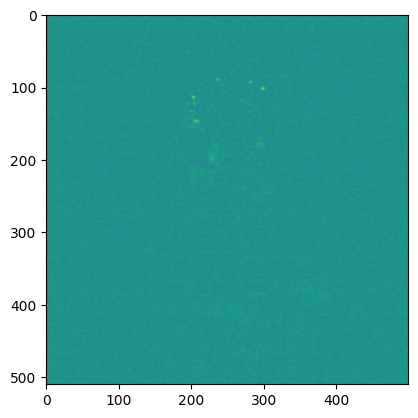

In [13]:
# check the range of values in the volumes
print(f"max: {d2_volumes.max()}, min: {d2_volumes.min()}")

# check a random slice of a volume, make sure it looks as expected ... 
plt.imshow(d2_volumes[T//2,Z//2,:,:],vmin = -100,vmax = 100)

You should see a slice of fish in the image abowe... 

## calculate and write t-score and diff images 
Create the folders to put images in: 

In [14]:
project.create("processed/tscore_volumes")

get a wrapper functins : 



In [15]:
# multiply difference image and t-score image by this constant before turning into integer and writing...
T_SCALE = 1000

def write_image(img, filename):
    tif.imwrite(filename,
                img.astype(np.uint16),shape=SHAPE,
                metadata={'spacing': RESOLUTION[0], 'unit': 'um','axes': 'ZYX'},
                resolution=(1/RESOLUTION[1], 1/RESOLUTION[2]),
                imagej=True)

def make_tscore(volumes1, volumes2, group_tag):
    """
    Creates and writes to dist a tscore image, based on the volumes pair provided. 
    """
    img = nu.get_t_score(volumes1, volumes2, absolute = True)*T_SCALE
    write_image(img, f'tscore_volumes/tscore_{group_tag}.tif')
    print(f'max t-image value : {img.max()}')
    return img

### 1. Write tscore and diff images for stimuli and stmuli vs blanks:

In [19]:
t_img = {"1vB1":[],"2vB2":[],"3vB3":[],"5vB5":[]}

tag = "1vB1"
print(f'{tag}_________________________________')
t_img[tag] = make_tscore(d1_volumes, b1_volumes, tag)

tag = "2vB2"
print(f'{tag}_________________________________')
t_img[tag] = make_tscore(d2_volumes, b2_volumes, tag)

tag = "3vB3"
print(f'{tag}_________________________________')
t_img[tag]  = make_tscore(d3_volumes, b3_volumes, tag)

tag = "4vB4"
print(f'{tag}_________________________________')
t_img[tag]  = make_tscore(d3_volumes, b3_volumes, tag)

tag = "5vB5"
print(f'{tag}_________________________________')
t_img[tag]  = make_tscore(d5_volumes, b5_volumes, tag)

1vB1_________________________________
max t-image value : 1281.107961826767
2vB2_________________________________
max t-image value : 1340.6099444064535
3vB3_________________________________
max t-image value : 1218.032806825213
4vB4_________________________________
max t-image value : 1218.032806825213
5vB5_________________________________
max t-image value : 1176.2264143238674


Create maximum and sum T-score and Defference images: highlight the largest changes through all different pairwis comparisons. 

In [20]:
t_max = np.maximum.reduce([t_img[tag] for tag in ["1vB1","2vB2","3vB3","4vB4","5vB5"]])
write_image(t_max, f'tscore_volumes/tscore_SvB_max.tif')

t_sum = np.add.reduce([t_img[tag] for tag in ["1vB1","2vB2","3vB3","4vB4","5vB5"]])
write_image(t_sum, f'tscore_volumes/tscore_SvB_sum.tif')

### 4. t-score images and diff images for random shuffle of blanks

In [22]:
project.create("processed/tscore_volumes/BvB")

np.random.seed(42)

blank_volumes = np.vstack([b1_volumes,b2_volumes,b3_volumes,b4_volumes,b5_volumes])

n_blanks = blank_volumes.shape[0]
n_stim = d2_volumes.shape[0]

split_idx = {}
for i_split in [1,2,3]:
    
    tag = f"BvB{i_split}"
    print(f'{tag}_________________________________')
    # choose how to split
    random_set = np.random.choice(n_blanks, size=n_stim*2, replace=False)
    split_idx[f'split{i_split} group1'] = random_set[0:n_stim]
    split_idx[f'split{i_split} group2'] = random_set[n_stim:n_stim*2]
    # get t-score
    vol1 = blank_volumes[split_idx[f'split{i_split} group1'],:,:,:]
    vol2 = blank_volumes[split_idx[f'split{i_split} group2'],:,:,:]
    make_tscore(vol1, vol2, tag)

split_df = pd.DataFrame.from_dict(split_idx)
split_df.to_csv('tscore_volumes/BvB_split_info.csv',index=False)

BvB1_________________________________
max t-image value : 1197.6651883200204
BvB2_________________________________
max t-image value : 1220.369150135753
BvB3_________________________________
max t-image value : 1246.3539056995116


# Now segment the t-score images and add to the project!

You can use any way to segment them, we found that using Imaris works really well!
If you use Imaris, **put the files that it produces into processed/spots/imaris**, see the schematics below, We will only need position and diameter, but you can dump all of them there ...


```
processed
│!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
│!!!!!!!!!!!!!!!! ATTENTION: MANUAL STEP !!!!!!!!!!!!!!!!!!
│!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
└───spots                                               !!!
│   └───imaris  <---------------------------- ATTENTION !!! You need to put stuff generated by imaris into this folder!!!                                         !!!
│       │   └───tscore_SvB_max_Statistics               !!!
│       │       │     tscore_SvB_max_Position.csv       !!!
│       │       │     tscore_SvB_max_Diameter.csv       !!!
│       │       │     ...                               !!!
│!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
│!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
│!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
```
The following cell will create the folder to put the files into

In [23]:
experiment.close()
project.create("processed/spots/imaris")